In [ ]:
# default_exp doublediff_analysis

In [ ]:
def calc_per_peppair_z_and_fcfc(overlapping_c1_idx, overlapping_c2_idx, ion1_c1_ints, ion1_c2_ints, ion2_c1_ints, ion2_c2_ints, ddeed_ion1_ion2):
    fcfc_res = 0
    count_fcfcs = 0
    z_summed = 0
    for idx1 in overlapping_c1_idx:
        for idx2 in overlapping_c2_idx:
            fc_ion1 = ion1_c1_ints[idx1] - ion1_c2_ints[idx2]
            fc_ion2 = ion2_c1_ints[idx1] - ion2_c2_ints[idx2]
            fcfc_idxpair = fc_ion1 - fc_ion2
            z_idxpair = ddeed_ion1_ion2.calc_zscore_from_fc(fcfc_idxpair)
            fcfc_res += fcfc_idxpair
            z_summed += z_idxpair
            count_fcfcs+=1
    if count_fcfcs==0:
        raise Exception("no idx overlap even though filtering has happened!")

    return z_summed, fcfc_res/count_fcfcs





def calculate_pairpair_overlap_factor(all_ionpairs, ion2pairs, ionpair2idx_ols, normed_c1, normed_c2, ion2diffdist, p2z):
    
    secondterm_variance = 0
    
    for ionpair in all_ionpairs:
        for ion in ionpair:
            compare_pairs = ion2pairs.get(ion)
            compare_pairs.remove(ionpair)
            
            for comp_ionpair in compare_pairs:

                comp_ion = comp_ionpair[0]

                idxs_ionpair = ionpair2idx_ols.get(ionpair)
                idxs_comp_ionpair = ionpair2idx_ols.get(comp_ionpair)
                
                n_sameidx_first = len(set(idxs_ionpair[0]).intersection(set(idxs_comp_ionpair[0])))
                n_sameidx_second = len(set(idxs_ionpair[1]).intersection(set(idxs_comp_ionpair[1])))

                deed1 = aqbg.get_subtracted_bg(ion2diffdist, normed_c1, normed_c2, ion, p2z)
                deed2 = aqbg.get_subtracted_bg(ion2diffdist, normed_c1, normed_c2, comp_ion, p2z)

                eed_ion_c1 = normed_c1.ion2background.get(ion)
                eed_ion_c2 = normed_c2.ion2background.get(ion)

                correlation_normfact = deed1.SD * deed2.SD
                
                var_overlap = len(idxs_ionpair[1])*len(idxs_comp_ionpair[1]) * n_sameidx_first * eed_ion_c1.var + len(idxs_ionpair[0])*len(idxs_comp_ionpair[0]) * n_sameidx_second * eed_ion_c2.var
                secondterm_variance += var_overlap/correlation_normfact
                
    return secondterm_variance

from scipy.stats import norm
def calculate_scaled_pval(z_sum, firstterm_variance, secondterm_variance):
    scaled_SD = np.sqrt((firstterm_variance+secondterm_variance))
    p_val = 2.0 * (1.0 -  norm(loc=0, scale= scaled_SD).cdf(abs(z_sum)))
    return p_val



In [ ]:
#export
import alphaquant.background_distributions as aqbg
import numpy as np


def calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist):
    z_total = 0
    fcfc_total = 0
    count_pairs = 0
    firstterm_variance = 0
    all_ionpairs = []
    ion2pairs = {}
    ionpair2idx_ols = {}

    nrep_c1 = len(normed_c1.ion2allvals.get(ions1[0]))
    nrep_c2 = len(normed_c2.ion2allvals.get(ions2[0]))
    
    for ion1 in ions1:
        ion1_c1_ints = normed_c1.ion2allvals.get(ion1)
        ion1_c2_ints = normed_c2.ion2allvals.get(ion1)
        for ion2 in ions2:
            ion2_c1_ints = normed_c1.ion2allvals.get(ion2)
            ion2_c2_ints = normed_c2.ion2allvals.get(ion2)

            #account for missing values: ion1 and ion2 values are only compared within the same sample -> filter for intensities that occur in the same sample for both ions
            overlapping_c1_idx = [x for x in range(nrep_c1) if (~np.isnan(ion1_c1_ints[x])) & (~np.isnan(ion2_c1_ints[x]))]
            nrep_ol_c1 = len(overlapping_c1_idx)
            if nrep_ol_c1 ==0:
                continue

            overlapping_c2_idx = [x for x in range(nrep_c2) if (~np.isnan(ion1_c2_ints[x])) & (~np.isnan(ion2_c2_ints[x]))]
            nrep_ol_c2 = len(overlapping_c2_idx)
            if nrep_ol_c2 ==0:
                continue

            #collection information for later variance calculation
            ionpair = (ion1, ion2)
            all_ionpairs.append(ionpair)
            ion2pairs[ion1] = ion2pairs.get(ion1, []) + [ionpair]
            ion2pairs[ion2] = ion2pairs.get(ion2, []) + [ionpair]
            ionpair2idx_ols[ionpair] = [overlapping_c1_idx, overlapping_c2_idx]

            #define all empirical error distributions (eed) and differential empirical error distributions (deed) and obtain the variance 
            eed_ion1_c1 = normed_c1.ion2background.get(ion1)
            eed_ion1_c2 = normed_c2.ion2background.get(ion1)

            eed_ion2_c1 = normed_c1.ion2background.get(ion2)
            eed_ion2_c2 = normed_c2.ion2background.get(ion2)

            deed_ion1 = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion1, p2z)
            deed_ion2 = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion2, p2z)

            #calculate the ionpair total variance as shown in Berchtold et al. EmpiReS

            ionpair_variance = (nrep_ol_c1 * nrep_ol_c2 *(deed_ion1.var + deed_ion2.var) + nrep_ol_c1 *nrep_ol_c2 *(nrep_ol_c2-1) * (eed_ion1_c1.var + eed_ion2_c1.var) +
             nrep_ol_c1 *nrep_ol_c2 *(nrep_ol_c1-1) * (eed_ion1_c2.var + eed_ion2_c2.var))/(deed_ion1.var + deed_ion2.var)

            firstterm_variance += ionpair_variance

            #calculate z-value and fcfc for the ion pair
            ddeed_ion1_ion2 = aqbg.get_doublediff_bg(deed_ion1, deed_ion2, deedpair2doublediffdist,p2z)
            z_pair, fcfc_pair = calc_per_peppair_z_and_fcfc(overlapping_c1_idx, overlapping_c2_idx, ion1_c1_ints, ion1_c2_ints, ion2_c1_ints, ion2_c2_ints, ddeed_ion1_ion2)
            z_total+=z_pair
            fcfc_total+=z_pair
            count_pairs+=1
    
    if count_pairs==0:
        return 
    secondterm_variance = calculate_pairpair_overlap_factor(all_ionpairs, ion2pairs, ionpair2idx_ols, normed_c1, normed_c2, ion2diffDist, p2z)
    fcfc = fcfc_total/count_pairs
    pval = calculate_scaled_pval(z_total, firstterm_variance, secondterm_variance)

    return fcfc, pval

In [ ]:

import uuid
import alphaquant.background_distributions as aqbg
import alphaquant.benchmarking as aqbm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def test_doublediff(num_ionsets = 10):

    sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7', 'B8', 'B9','B10', 'B11', 'B12'],
    'condition' : ['A', 'A', 'A', 'B', 'B', 'B','B', 'B', 'B','B', 'B', 'B','B', 'B', 'B']})
    unnormed_df = aqbm.generate_random_input(1000, sample2cond_df,simulate_nas=True)
    df_c1, df_c2 = get_c1_c2_dfs(unnormed_df, sample2cond_df, ["A", "B"])
    p2z = {}
    normed_c1 = aqbg.ConditionBackgrounds(df_c1, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2, p2z)
    pvals = test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets)
    return pvals


def test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets = 10):
    pvals = []
    allions = list(set(normed_c1.ion2background.keys()).intersection(set(normed_c2.ion2background.keys())))
    allions = np.array(allions)
    
    ionsets = [allions[np.random.randint(len(allions), size=np.random.randint(1,10))] for _ in range(num_ionsets)]
    
    print(np.random.randint(1,10))
    print(allions[np.random.randint(1,10)])
    print(allions[np.random.randint(1,10)])
    count_iters = 0
    ion2diffDist={} 
    p2z ={} 
    deedpair2doublediffdist = {}

    for ions1, ions2 in itertools.combinations(ionsets, 2):
        print(f"ionpair {len(ions1)} {len(ions2)}\n{count_iters} of {len(ionsets)*(len(ionsets)-1)/2}")
        count_iters+=1
        _, p = calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist,p2z, deedpair2doublediffdist)
        pvals.append(p)
    
    return pvals
    

def get_c1_c2_dfs(unnormed_df, labelmap_df, condpair, minrep = 2):
    c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
    c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
    df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
    df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)

    return df_c1, df_c2


pvals = test_doublediff(300)



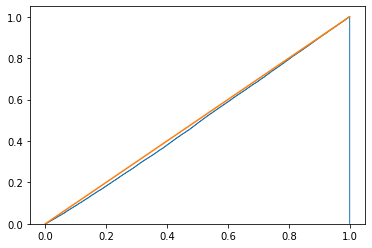

KstestResult(statistic=0.034205128205128194, pvalue=0.19805567202904573)

In [ ]:
import alphaquant.visualizations as aqviz
import scipy.stats as stats

plt.hist(pvals, cumulative=True, bins = 1000, histtype = "step", density = True)
x = np.linspace(0,1,100)
plt.plot(x, x)
plt.show()
unidist = np.random.uniform(size=1000)

res = stats.ks_2samp(pvals, unidist)
display(res)
#assert statement can be placed here!